In [102]:
import os
import re
import json
import glob
import pickle
import string
import itertools
import collections
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
tqdm.pandas()

In [3]:
pd.set_option('display.max_rows', 10)

In [4]:
# input path
SUPPORT_PATH = "../data/supports"

In [5]:
def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [6]:
d_199 = read_pickle(os.path.join(SUPPORT_PATH, "parsed_199.pkl"))
d_6725 = read_pickle(os.path.join(SUPPORT_PATH, "parsed_7003.pkl"))
d_tweets = pd.concat([d_199, d_6725], axis = 0, sort=False)
d_tweets.drop_duplicates(subset="id_tweet", inplace=True)
d_tweets.reset_index(drop=True, inplace=True)

In [7]:
d_label = pd.read_csv("../data/account_labeled/label_updated.csv")

In [8]:
d_label.head()

,screen_name,label
0,4SinCong,NaN
1,4rdipratama,NaN
2,ABackBone,NaN
3,ATAP03167829,NaN
4,AbdeeProklamasi,NaN


In [9]:
d_label.shape

(39353, 2)

In [10]:
d_tweets.head()

,screen_name,id_tweet,full_text,hashtags,user_mentions,created_at,quote_is_quote_status,quote_screen_name,quote_id_tweet,quote_full_text,quote_hashtags,quote_user_mentions,quote_created_at,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name
0,212Ujee2,1272955449160040449,#HapusRUUHIPDariMukaBumi \n#HapusRUUHIPDariMuk...,"[{'text': 'HapusRUUHIPDariMukaBumi', 'indices'...",[],Tue Jun 16 18:13:24 +0000 2020,True,Par3w4_Minang,1272901801516335112,Moncong putih ingin cuci tangan \n\nKata si Po...,[],[],Tue Jun 16 14:40:13 +0000 2020,NaN,NaN,NaN
1,212Ujee2,1272573148974571526,Sampah n benalu\nPerusak demokrasi wajib kita ...,"[{'text': 'BuzzeRpPublicEnemy', 'indices': [59...",[],Mon Jun 15 16:54:16 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,212Ujee2,1272242834725208064,Saatnya kita bersatu\nWahai umat Islam\n\n#Sto...,"[{'text': 'Stop_RUUHIP', 'indices': [39, 51]},...",[],Sun Jun 14 19:01:43 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,212Ujee2,1267860265694978049,Umat Islam\nHrs diam \nTerus sampai kapan?\nKe...,"[{'text': 'BalikinDanaHaji', 'indices': [104, ...",[],Tue Jun 02 16:46:57 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,212Ujee2,1266354000716107780,Hai Pemimpin !!!\nApakah udh ga ada lagi \nPro...,"[{'text': 'DirutBokep', 'indices': [204, 215]}...","[{'screen_name': '__p3jalan____', 'name': 'p3j...",Fri May 29 13:01:36 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
d_tweets.shape

(1983967, 16)

In [12]:
d_label = d_label[~d_label.label.isna()]

In [13]:
d_label.head()

,screen_name,label
33186,02Trus,buzzer
33188,0b4tk3lu4r94,non-buzzer
33190,0mega01,buzzer
33191,0v4lt1n3_,non-buzzer
33193,17Mutawakkil,non-buzzer


In [14]:
d_label.label.value_counts()

non-buzzer    2094
buzzer         713
Name: label, dtype: int64

In [15]:
# 2797 accounts are labeled, the rest are excluded before parsing
d_tweets[d_tweets.screen_name.isin(d_label.screen_name)].screen_name.unique().shape

(2797,)

In [16]:
d_dataset = d_tweets.groupby('screen_name')['full_text'].apply(list)
d_dataset = d_dataset.reset_index()

# join dataset and label
d_dataset = d_dataset.join(d_label.set_index('screen_name'), on='screen_name')

In [17]:
def get_profile_key(screen_name, key):
    profile_path = os.path.join(f"../data/profile/{screen_name}.json")
    if os.path.exists(profile_path):
        with open(profile_path) as f:
            data = json.load(f)
            if isinstance(data, dict):
                return data.get(key, None)
            else:
                return None

In [18]:
# get verified
d_dataset["is_verified"] = d_dataset.screen_name.progress_apply(get_profile_key, args=('verified', ))

100%|████████████████████████████████████████████████████████████████████████████| 6866/6866 [00:02<00:00, 3001.02it/s]


In [19]:
d_dataset.is_verified.value_counts()

False    2986
True       96
Name: is_verified, dtype: int64

In [20]:
# get description profile
d_dataset["profile_description"] = d_dataset.screen_name.progress_apply(get_profile_key, args=('description', ))

100%|████████████████████████████████████████████████████████████████████████████| 6866/6866 [00:02<00:00, 3301.61it/s]


In [21]:
def check_akun_resmi(description):
    if description:
        if re.search("akun .* resmi", description.lower()):
            return True
        else:
            return False
    else:
        return False

In [22]:
d_dataset["is_akun_resmi"] = d_dataset.profile_description.apply(check_akun_resmi)

In [23]:
d_dataset.loc[:, 'num_tweets'] = d_dataset.full_text.apply(lambda x : len(x))

In [24]:
d_dataset2 = d_dataset[d_dataset.num_tweets >= 20]

In [25]:
d_dataset.shape

(6866, 7)

In [26]:
d_dataset2.shape

(6730, 7)

In [27]:
# using 10 samples
d_dataset2['text_used'] = d_dataset2.full_text.apply(lambda x: " ".join(x[:30]))

C:\Users\Andreas Chandra\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
d_dataset2.shape

(6730, 8)

In [29]:
d_dataset2 = d_dataset2[(d_dataset2.is_verified == False) & (d_dataset2.is_akun_resmi == False)]

In [30]:
d_dataset2.shape

(2968, 8)

In [31]:
d_train = d_dataset2[d_dataset2.label.notna()]

In [32]:
d_train.reset_index(drop=True, inplace=True)

In [33]:
d_train.shape

(1333, 8)

In [34]:
def text_cleansing(title):
    punctuation = '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'
    table = str.maketrans(punctuation, ' '*len(punctuation)) #map punctuation to space
    
    # parse hashtag
    title = re.sub(r"([a-z])([A-Z])", r"\1 \2", title)
    # lowercase
    title = title.lower()
    # convert hyperlinks to link
#     title = re.sub('http(s):/\/\\S+', '<LINK> ', title)
    title = re.sub('http(s):/\/\\S+', ' ', title)
    # convert @username to username
#     title = re.sub('@\w+', '<USERNAME>', title)
    title = re.sub('@\w+', ' ', title)
    # remove punctuation
    title = title.translate(table)
    # only take string started with alphanum
    title = re.sub("[^(\w|\<\>)]", ' ', title)
    # remove double whitespaces
    title = re.sub('\s+', ' ', title)
    # remove double whitespaces
    title = title.strip()
    
    return title

In [35]:
d_train["preprocessed_text"] = d_train.text_used.apply(text_cleansing)

C:\Users\Andreas Chandra\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
d_train.loc[:, 'preprocessed_text_token'] = d_train.preprocessed_text.apply(word_tokenize)

c:\users\andreas chandra\appdata\local\continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\andreas chandra\appdata\local\continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [37]:
d_train

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text,preprocessed_text_token
0,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,non-buzzer,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...,"[sebentar, bentar, gue, hrs, inget2, nih, beru..."
1,0mega01,[Tayang #programfolback \n#MutualMilenial \nFo...,buzzer,False,Love is infinite. There is no beginning and no...,False,143,Tayang #programfolback \n#MutualMilenial \nFol...,tayang programfolback mutual milenial follow c...,"[tayang, programfolback, mutual, milenial, fol..."
2,0v4lt1n3_,[..dan produk yang pro-Zionis. \n\nSayang.. Te...,non-buzzer,False,You Will Never Know 🇮🇩🇵🇸 /// udah Sekolah ...,False,300,..dan produk yang pro-Zionis. \n\nSayang.. Ter...,dan produk yang pro zionis sayang terlambat se...,"[dan, produk, yang, pro, zionis, sayang, terla..."
3,19as_don,[---Kesenjangan Pendidikan di Masa Pandemi Cov...,non-buzzer,False,apalah dayaku,False,300,---Kesenjangan Pendidikan di Masa Pandemi Covi...,kesenjangan pendidikan di masa pandemi covid 1...,"[kesenjangan, pendidikan, di, masa, pandemi, c..."
4,20dnosebleed,[this is m*rc0 pan@ri hate account. dari dulu ...,non-buzzer,False,"runtuh, tumbuh. terbentur, terbentur, terbentu...",False,300,this is m*rc0 pan@ri hate account. dari dulu j...,this is m rc0 pan hate account dari dulu juga ...,"[this, is, m, rc0, pan, hate, account, dari, d..."
...,...,...,...,...,...,...,...,...,...,...
1328,zonasubang,[[POTO] Aktivitas Warga di Alun-alun Subang di...,non-buzzer,False,tempat kamu curhat tentang sesuatu yang gak ka...,False,300,[POTO] Aktivitas Warga di Alun-alun Subang di ...,poto aktivitas warga di alun alun subang di aw...,"[poto, aktivitas, warga, di, alun, alun, suban..."
1329,zulfikarzat31,[Baru saja mengirim foto https://t.co/xh415Eyj...,non-buzzer,False,"💗Di beranda, kita pernah lupa bahwa cinta bisa...",False,300,Baru saja mengirim foto https://t.co/xh415Eyj2...,baru saja mengirim foto ijin share qah sisa ha...,"[baru, saja, mengirim, foto, ijin, share, qah,..."
1330,zulhermansyah97,[👁 Siapa yang melawat profil anda? 👁\n@ArifinN...,non-buzzer,False,Lelah 🔜 Lillah,False,300,👁 Siapa yang melawat profil anda? 👁\n@ArifinNa...,siapa yang melawat profil anda naftalia gt 11 ...,"[siapa, yang, melawat, profil, anda, naftalia,..."
1331,zulman1,[Hmm bisa di coba ini wkwkw https://t.co/qCGES...,non-buzzer,False,Juru tulis kapal bajak laut yang sedang berlay...,False,300,Hmm bisa di coba ini wkwkw https://t.co/qCGESp...,hmm bisa di coba ini wkwkw cgesp wyw h garuda ...,"[hmm, bisa, di, coba, ini, wkwkw, cgesp, wyw, ..."


In [38]:
all_words = itertools.chain.from_iterable(d_train.preprocessed_text_token)

In [39]:
all_words = list(all_words)

In [40]:
vocab_freq = collections.Counter(all_words)

In [41]:
d_vocab_freq = pd.DataFrame(vocab_freq.items(), columns=["word", "freq"]).sort_values("freq", ascending=False)

In [42]:
stop_words = d_vocab_freq[(d_vocab_freq.freq <= 2) | (d_vocab_freq.freq >= 2500)].word.to_list()

In [53]:
vocab_used = d_vocab_freq[d_vocab_freq.freq.between(2, 2500)].word.to_list()

In [72]:
vocab_used2 = list(filter(lambda x: True if (len(x) > 2) & (not x.isnumeric()) else False, vocab_used))

In [73]:
len(vocab_used2)

25069

In [75]:
vocab_used2 = sorted(vocab_used2)

In [76]:
d_train

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text,preprocessed_text_token
0,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,non-buzzer,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...,"[sebentar, bentar, gue, hrs, inget2, nih, beru..."
1,0mega01,[Tayang #programfolback \n#MutualMilenial \nFo...,buzzer,False,Love is infinite. There is no beginning and no...,False,143,Tayang #programfolback \n#MutualMilenial \nFol...,tayang programfolback mutual milenial follow c...,"[tayang, programfolback, mutual, milenial, fol..."
2,0v4lt1n3_,[..dan produk yang pro-Zionis. \n\nSayang.. Te...,non-buzzer,False,You Will Never Know 🇮🇩🇵🇸 /// udah Sekolah ...,False,300,..dan produk yang pro-Zionis. \n\nSayang.. Ter...,dan produk yang pro zionis sayang terlambat se...,"[dan, produk, yang, pro, zionis, sayang, terla..."
3,19as_don,[---Kesenjangan Pendidikan di Masa Pandemi Cov...,non-buzzer,False,apalah dayaku,False,300,---Kesenjangan Pendidikan di Masa Pandemi Covi...,kesenjangan pendidikan di masa pandemi covid 1...,"[kesenjangan, pendidikan, di, masa, pandemi, c..."
4,20dnosebleed,[this is m*rc0 pan@ri hate account. dari dulu ...,non-buzzer,False,"runtuh, tumbuh. terbentur, terbentur, terbentu...",False,300,this is m*rc0 pan@ri hate account. dari dulu j...,this is m rc0 pan hate account dari dulu juga ...,"[this, is, m, rc0, pan, hate, account, dari, d..."
...,...,...,...,...,...,...,...,...,...,...
1328,zonasubang,[[POTO] Aktivitas Warga di Alun-alun Subang di...,non-buzzer,False,tempat kamu curhat tentang sesuatu yang gak ka...,False,300,[POTO] Aktivitas Warga di Alun-alun Subang di ...,poto aktivitas warga di alun alun subang di aw...,"[poto, aktivitas, warga, di, alun, alun, suban..."
1329,zulfikarzat31,[Baru saja mengirim foto https://t.co/xh415Eyj...,non-buzzer,False,"💗Di beranda, kita pernah lupa bahwa cinta bisa...",False,300,Baru saja mengirim foto https://t.co/xh415Eyj2...,baru saja mengirim foto ijin share qah sisa ha...,"[baru, saja, mengirim, foto, ijin, share, qah,..."
1330,zulhermansyah97,[👁 Siapa yang melawat profil anda? 👁\n@ArifinN...,non-buzzer,False,Lelah 🔜 Lillah,False,300,👁 Siapa yang melawat profil anda? 👁\n@ArifinNa...,siapa yang melawat profil anda naftalia gt 11 ...,"[siapa, yang, melawat, profil, anda, naftalia,..."
1331,zulman1,[Hmm bisa di coba ini wkwkw https://t.co/qCGES...,non-buzzer,False,Juru tulis kapal bajak laut yang sedang berlay...,False,300,Hmm bisa di coba ini wkwkw https://t.co/qCGESp...,hmm bisa di coba ini wkwkw cgesp wyw h garuda ...,"[hmm, bisa, di, coba, ini, wkwkw, cgesp, wyw, ..."


In [77]:
d_train

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text,preprocessed_text_token
0,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,non-buzzer,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...,"[sebentar, bentar, gue, hrs, inget2, nih, beru..."
1,0mega01,[Tayang #programfolback \n#MutualMilenial \nFo...,buzzer,False,Love is infinite. There is no beginning and no...,False,143,Tayang #programfolback \n#MutualMilenial \nFol...,tayang programfolback mutual milenial follow c...,"[tayang, programfolback, mutual, milenial, fol..."
2,0v4lt1n3_,[..dan produk yang pro-Zionis. \n\nSayang.. Te...,non-buzzer,False,You Will Never Know 🇮🇩🇵🇸 /// udah Sekolah ...,False,300,..dan produk yang pro-Zionis. \n\nSayang.. Ter...,dan produk yang pro zionis sayang terlambat se...,"[dan, produk, yang, pro, zionis, sayang, terla..."
3,19as_don,[---Kesenjangan Pendidikan di Masa Pandemi Cov...,non-buzzer,False,apalah dayaku,False,300,---Kesenjangan Pendidikan di Masa Pandemi Covi...,kesenjangan pendidikan di masa pandemi covid 1...,"[kesenjangan, pendidikan, di, masa, pandemi, c..."
4,20dnosebleed,[this is m*rc0 pan@ri hate account. dari dulu ...,non-buzzer,False,"runtuh, tumbuh. terbentur, terbentur, terbentu...",False,300,this is m*rc0 pan@ri hate account. dari dulu j...,this is m rc0 pan hate account dari dulu juga ...,"[this, is, m, rc0, pan, hate, account, dari, d..."
...,...,...,...,...,...,...,...,...,...,...
1328,zonasubang,[[POTO] Aktivitas Warga di Alun-alun Subang di...,non-buzzer,False,tempat kamu curhat tentang sesuatu yang gak ka...,False,300,[POTO] Aktivitas Warga di Alun-alun Subang di ...,poto aktivitas warga di alun alun subang di aw...,"[poto, aktivitas, warga, di, alun, alun, suban..."
1329,zulfikarzat31,[Baru saja mengirim foto https://t.co/xh415Eyj...,non-buzzer,False,"💗Di beranda, kita pernah lupa bahwa cinta bisa...",False,300,Baru saja mengirim foto https://t.co/xh415Eyj2...,baru saja mengirim foto ijin share qah sisa ha...,"[baru, saja, mengirim, foto, ijin, share, qah,..."
1330,zulhermansyah97,[👁 Siapa yang melawat profil anda? 👁\n@ArifinN...,non-buzzer,False,Lelah 🔜 Lillah,False,300,👁 Siapa yang melawat profil anda? 👁\n@ArifinNa...,siapa yang melawat profil anda naftalia gt 11 ...,"[siapa, yang, melawat, profil, anda, naftalia,..."
1331,zulman1,[Hmm bisa di coba ini wkwkw https://t.co/qCGES...,non-buzzer,False,Juru tulis kapal bajak laut yang sedang berlay...,False,300,Hmm bisa di coba ini wkwkw https://t.co/qCGESp...,hmm bisa di coba ini wkwkw cgesp wyw h garuda ...,"[hmm, bisa, di, coba, ini, wkwkw, cgesp, wyw, ..."


In [78]:
d_train.loc[:, "label_encoded"] = d_train.label.map({'buzzer': 1, 'non-buzzer': 0})

c:\users\andreas chandra\appdata\local\continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\andreas chandra\appdata\local\continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [116]:
d_train.label.value_counts()

non-buzzer    1066
buzzer         267
Name: label, dtype: int64

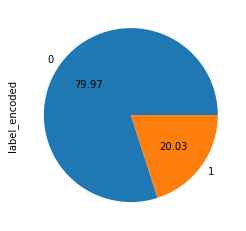

In [79]:
d_train.label_encoded.value_counts().plot(kind='pie', autopct='%.2f')

#### Creating Count Matrix

In [86]:
d_train

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text,preprocessed_text_token,label_encoded
0,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,non-buzzer,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...,"[sebentar, bentar, gue, hrs, inget2, nih, beru...",0
1,0mega01,[Tayang #programfolback \n#MutualMilenial \nFo...,buzzer,False,Love is infinite. There is no beginning and no...,False,143,Tayang #programfolback \n#MutualMilenial \nFol...,tayang programfolback mutual milenial follow c...,"[tayang, programfolback, mutual, milenial, fol...",1
2,0v4lt1n3_,[..dan produk yang pro-Zionis. \n\nSayang.. Te...,non-buzzer,False,You Will Never Know 🇮🇩🇵🇸 /// udah Sekolah ...,False,300,..dan produk yang pro-Zionis. \n\nSayang.. Ter...,dan produk yang pro zionis sayang terlambat se...,"[dan, produk, yang, pro, zionis, sayang, terla...",0
3,19as_don,[---Kesenjangan Pendidikan di Masa Pandemi Cov...,non-buzzer,False,apalah dayaku,False,300,---Kesenjangan Pendidikan di Masa Pandemi Covi...,kesenjangan pendidikan di masa pandemi covid 1...,"[kesenjangan, pendidikan, di, masa, pandemi, c...",0
4,20dnosebleed,[this is m*rc0 pan@ri hate account. dari dulu ...,non-buzzer,False,"runtuh, tumbuh. terbentur, terbentur, terbentu...",False,300,this is m*rc0 pan@ri hate account. dari dulu j...,this is m rc0 pan hate account dari dulu juga ...,"[this, is, m, rc0, pan, hate, account, dari, d...",0
...,...,...,...,...,...,...,...,...,...,...,...
1328,zonasubang,[[POTO] Aktivitas Warga di Alun-alun Subang di...,non-buzzer,False,tempat kamu curhat tentang sesuatu yang gak ka...,False,300,[POTO] Aktivitas Warga di Alun-alun Subang di ...,poto aktivitas warga di alun alun subang di aw...,"[poto, aktivitas, warga, di, alun, alun, suban...",0
1329,zulfikarzat31,[Baru saja mengirim foto https://t.co/xh415Eyj...,non-buzzer,False,"💗Di beranda, kita pernah lupa bahwa cinta bisa...",False,300,Baru saja mengirim foto https://t.co/xh415Eyj2...,baru saja mengirim foto ijin share qah sisa ha...,"[baru, saja, mengirim, foto, ijin, share, qah,...",0
1330,zulhermansyah97,[👁 Siapa yang melawat profil anda? 👁\n@ArifinN...,non-buzzer,False,Lelah 🔜 Lillah,False,300,👁 Siapa yang melawat profil anda? 👁\n@ArifinNa...,siapa yang melawat profil anda naftalia gt 11 ...,"[siapa, yang, melawat, profil, anda, naftalia,...",0
1331,zulman1,[Hmm bisa di coba ini wkwkw https://t.co/qCGES...,non-buzzer,False,Juru tulis kapal bajak laut yang sedang berlay...,False,300,Hmm bisa di coba ini wkwkw https://t.co/qCGESp...,hmm bisa di coba ini wkwkw cgesp wyw h garuda ...,"[hmm, bisa, di, coba, ini, wkwkw, cgesp, wyw, ...",0


In [81]:
d_train.shape

(1333, 11)

In [84]:
X_count = np.zeros((len(d_train), len(vocab_used2)))

In [88]:
vocab_used[0]

'aku'

In [91]:
for idx, token_list in tqdm(enumerate(d_train.preprocessed_text_token)):
    for token in token_list:
        try:
            X_count[idx, vocab_used2.index(token)] += 1
        except:
            pass

1333it [09:38,  2.30it/s]


### Exprimenting with simple algorithm

In [103]:
# tfidf = TfidfVectorizer()
tfidf = TfidfTransformer()

In [104]:
# text_tfidf = tfidf.fit_transform(d_train.preprocessed_text)
text_tfidf = tfidf.fit_transform(X_count)

In [105]:
text_tfidf.shape

(1333, 25069)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, d_train.label_encoded, test_size=0.2, random_state=123)

In [107]:
y_train.value_counts()

0    853
1    213
Name: label_encoded, dtype: int64

In [108]:
y_test.value_counts()

0    213
1     54
Name: label_encoded, dtype: int64

In [109]:
def scoring(y_test, y_pred):
    
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"accuracy: {acc:.2f} | precision: {pre:.2f} | recall: {rec:.2f} | f score: {f1:.2f}")

In [110]:
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.82 | precision: 0.54 | recall: 0.69 | f score: 0.61


In [111]:
model = SVC(gamma='scale', kernel='linear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.87 | precision: 0.69 | recall: 0.65 | f score: 0.67


In [112]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.85 | precision: 0.74 | recall: 0.43 | f score: 0.54


In [113]:
model = GradientBoostingClassifier(n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.87 | precision: 0.72 | recall: 0.54 | f score: 0.62


In [114]:
model = AdaBoostClassifier(n_estimators=400)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scoring(y_test, y_pred)

accuracy: 0.84 | precision: 0.60 | recall: 0.56 | f score: 0.58
